# 1. Problem Statement
## ML-Based System-Level Parameter Estimation of Frequency Selective Surfaces (FSS) in Sub-6 GHz Bands

## Random Forest Regression with Physics-Aware Synthetic Data

# 2. Libraries/Imports

In [51]:
# Libraries/Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## SKlearn
from sklearn.model_selection import train_test_split # train test split
from sklearn.ensemble import RandomForestRegressor # regressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Metrics

## reproducibility
np.random.seed(42)


# 3. FSS-physics-aware Synthetic data generation

In [52]:
# 3. FSS-physics-aware- heurristic approach- Synthetic data generation
## FSS: A simple square loop with dielectric substrate.

def generate_synthetic_fss_data(n_samples=2000):
    # FSS Geometry & material parameters
    d = np.random.uniform(5.5, 18.0, n_samples) # FSS element size, mm
    p = np.random.uniform(7.0, 24.0, n_samples) # FSS periodicity, mm
    w = np.random.uniform(0.2, 5.0, n_samples)     # metallic strip width, mm
    eps_r = np.random.uniform(2.2, 6.0, n_samples)    # substrate permittivity
    f_center = np.random.uniform(2.0, 6.0, n_samples)   # system frequency in GHz

    # Effective permittivity
    eps_eff = 0.5 * (1 + eps_r)

    # Effective electrical length- to capture the general trends based on antenna theory.
    L_eff = d + 0.15 * p

    # Resonance frequency: Antenna theory- general trend.
    f_res = 110 / (L_eff * np.sqrt(eps_eff))
    f_res += np.random.normal(0, 0.03, n_samples)  # Include small modeling noise

    # Minimum S21 (stronger metal & coupling → deeper stopband)
    S21_min = -(10 + 120 * (w / p) / np.sqrt(eps_r))# Qualitatie appriach. Not exact analytical.
    S21_min = np.clip(S21_min, -40, -5)
    S21_min += np.random.normal(0, 0.5, n_samples)

    # Bandwidth definition (-10 dB), depending on width, size, periodicity, permittivity
    BW_10dB = (0.25 + 0.8 * (w / d) + 0.3 / (p / 10)) / np.sqrt(eps_r) # Qualitative approach
    BW_10dB = np.clip(BW_10dB, 0.1, 2.0) # Cliping to limit.

    # Feature variables- Data Frame.
    X = pd.DataFrame({
        "d_mm": d,
        "p_mm": p,
        "w_mm": w,
        "eps_r": eps_r,
        "f_center_ghz": f_center
    })

    # Target variables- Data Frame.
    y = pd.DataFrame({
        "f_res_ghz": f_res,
        "BW_10dB_ghz": BW_10dB,
        "S21_min_dB": S21_min
    })

    return X, y


In [53]:
#X.head()

# 4. Pandas dataframe dataset: .CSV format

In [54]:
# 4. Pandas dataframe dataset: .CSV format
# Call the function to generate the data with 2000 rows, 8 columns
X, y = generate_synthetic_fss_data()

dataset = pd.concat([X, y], axis=1) # to make proper sheet contaning both X and y
dataset.to_csv("synthetic_fss_dataset.csv", index=False) # .csv format

print("dataset, file name: synthetic_fss_dataset.csv")
print("Dataset shape:", dataset.shape)
display(dataset.head())

dataset, file name: synthetic_fss_dataset.csv
Dataset shape: (2000, 8)


,d_mm,p_mm,w_mm,eps_r,f_center_ghz,f_res_ghz,BW_10dB_ghz,S21_min_dB
0,10.181751,11.448997,2.945580,4.663376,4.881072,5.448949,0.344282,-23.829328
1,17.383929,11.198640,4.066075,2.855068,4.749132,4.122324,0.417240,-35.600987
2,14.649924,22.406328,3.848772,5.515099,2.383017,3.395525,0.252963,-19.335866
3,12.983231,11.242285,0.938720,4.529842,5.690290,4.474340,0.270018,-14.728578
4,7.450233,11.623145,0.916397,2.797375,4.273889,8.716491,0.362628,-15.171495


# 5. Data Preprocessing- Train/Test split

In [55]:
# 5. Data Preprocessing- Train/Test split
## 80% trainng. 20% test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 5), (400, 5), (1600, 3), (400, 3))

# 6. Train Random Forest Model

In [56]:
# 6. Train Random Forest Model

rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1) # object
rf.fit(X_train, y_train) # Training

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

# 7. Predictions and standard ML metrics

In [57]:
# 7. Predictions and standard ML metrics

y_pred = rf.predict(X_test) # Prediction on Test data (20%)

# Evaluation Metrics based on predicted values on test data.
print("\nEvaluation Metrics (Test Set):")
for i, target in enumerate(y.columns):
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i]) # MAE
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i])) # RMSE
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i]) # R2
    print(f"{target:15s} | MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")



Evaluation Metrics (Test Set):
f_res_ghz       | MAE=0.330, RMSE=0.490, R2=0.913
BW_10dB_ghz     | MAE=0.016, RMSE=0.023, R2=0.928
S21_min_dB      | MAE=0.740, RMSE=0.984, R2=0.982


In [58]:
#y_pred

# 8. Prediction vs Ground Truth

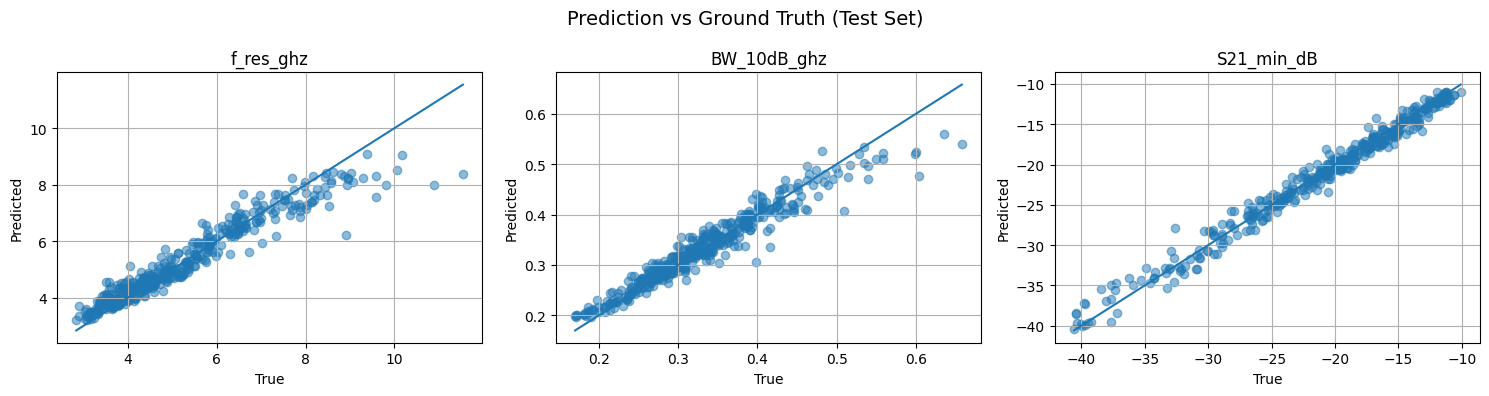

In [59]:
# 8. Prediction values vs Ground Truth values
## Plot for Prdicted vs Trze value for each Targets: f_res_ghz, BW_10dB_ghz, S21_min_dB
plt.figure(figsize=(15,4))

for i, target in enumerate(y.columns):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.5)
    plt.plot(
        [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
        [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()]
    )
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(target)
    plt.grid(True)

plt.suptitle("Prediction vs Ground Truth (Test Set)", fontsize=14)
plt.tight_layout()
plt.show()



# 9. Feature importance: Interpretability

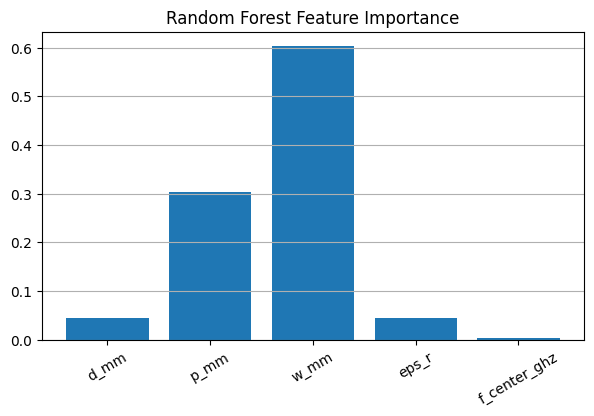

In [60]:
# 9. Feature importance: Interpretability
## To understand which features has higher impact on the result..
plt.figure(figsize=(7,4))
plt.bar(X.columns, rf.feature_importances_) # Feature importance check.
plt.title("Random Forest Feature Importance")
plt.xticks(rotation=30)
plt.grid(axis="y")
plt.show()


# 10. Dependence of Target variables with Features

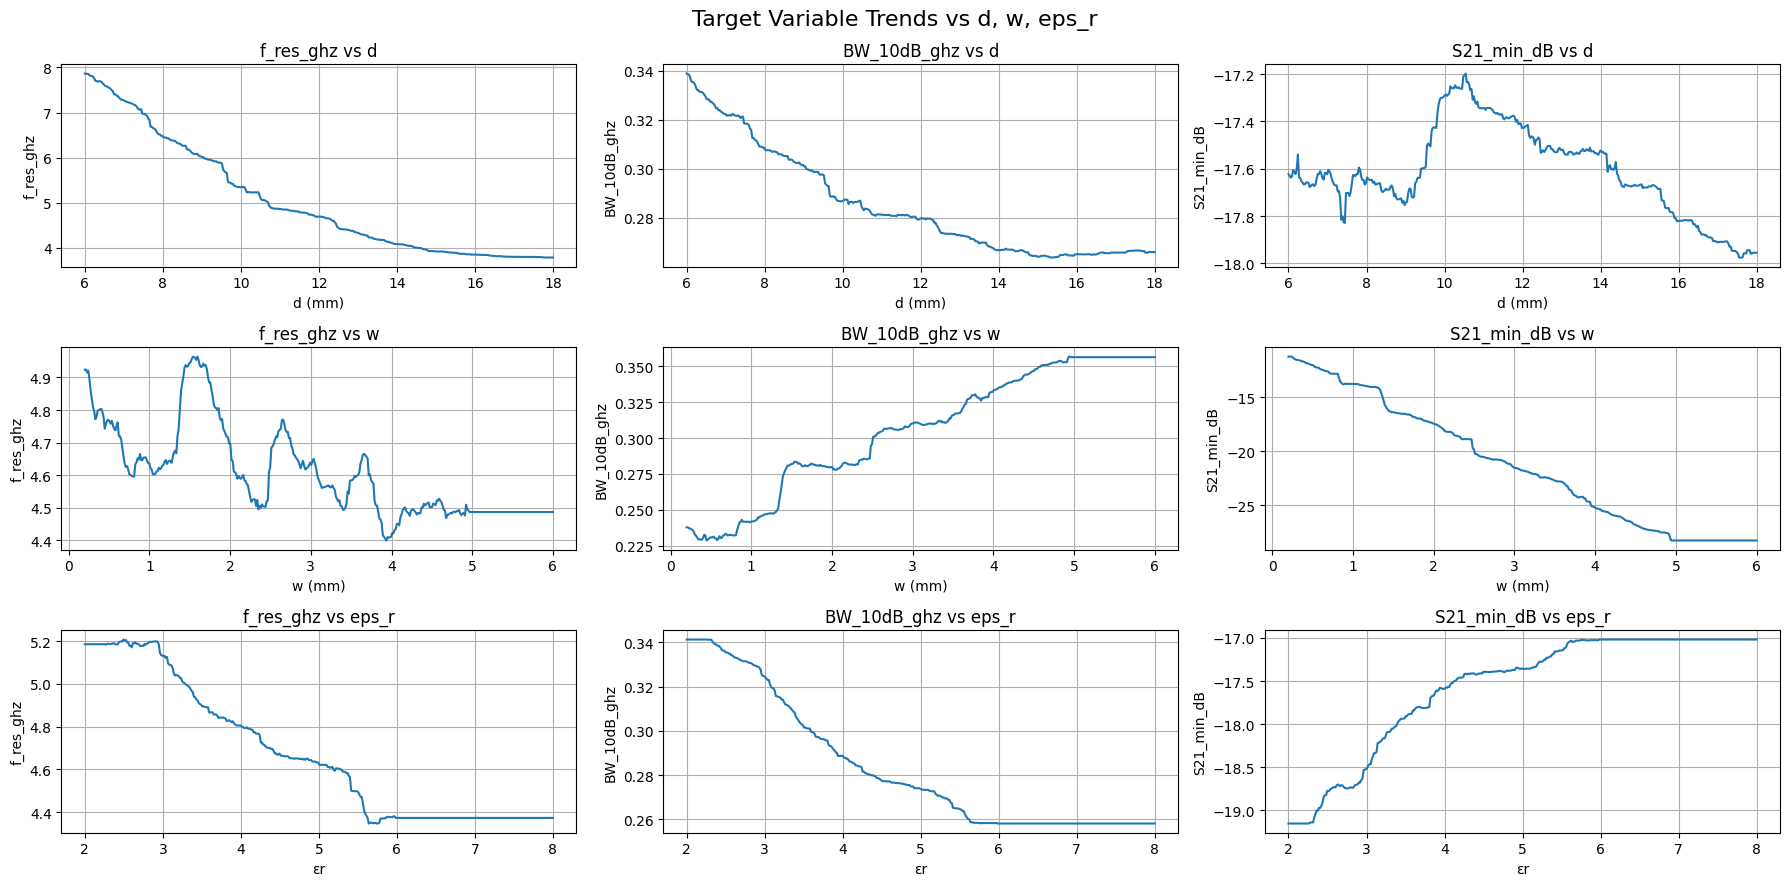

In [61]:
# 10. Dependance of Target variable with Features
## Check how the target value varies with the variations in the design parameters.
## Perfomed w.r.t. three design parameetrs: d, w and permitivity eps_r: for each target variables.
targets = y.columns.tolist()

# element size d
d_sweep = np.linspace(6, 18, 400) # 400 samples.
X_d = pd.DataFrame({
    "d_mm": d_sweep,
    "p_mm": 15.0,
    "w_mm": 2.0,
    "eps_r": 4.4,
    "f_center_ghz": 3.5
})
y_d = rf.predict(X_d) # prediction on the amples.

# Strip width w
w_sweep = np.linspace(0.2, 6.0, 400) # 400 samples.
X_w = pd.DataFrame({
    "d_mm": 12.0,
    "p_mm": 15.0,
    "w_mm": w_sweep,
    "eps_r": 4.4,
    "f_center_ghz": 3.5
})
y_w = rf.predict(X_w) # prediction on the amples.

# Substrate permittivity eps_r
eps_sweep = np.linspace(2.0, 8.0, 400) # 400 samples.
X_eps = pd.DataFrame({
    "d_mm": 12.0,
    "p_mm": 15.0,
    "w_mm": 2.0,
    "eps_r": eps_sweep,
    "f_center_ghz": 3.5
})
y_eps = rf.predict(X_eps) # prediction on the amples.

# Plot all
plt.figure(figsize=(18,9))

for i, target in enumerate(targets):
    plt.subplot(3, 3, i+1)
    plt.plot(d_sweep, y_d[:, i]) # d
    plt.xlabel("d (mm)")
    plt.ylabel(target)
    plt.title(f"{target} vs d")
    plt.grid(True)

    plt.subplot(3, 3, i+4)
    plt.plot(w_sweep, y_w[:, i]) # w
    plt.xlabel("w (mm)")
    plt.ylabel(target)
    plt.title(f"{target} vs w")
    plt.grid(True)

    plt.subplot(3, 3, i+7)
    plt.plot(eps_sweep, y_eps[:, i]) # eps
    plt.xlabel("εr")
    plt.ylabel(target)
    plt.title(f"{target} vs eps_r")
    plt.grid(True)

plt.suptitle("Target Variable Trends vs d, w, eps_r", fontsize=16)
plt.tight_layout()
plt.show()

